# XGBoost model

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

%matplotlib inline

In [2]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()

In [3]:
data_dir = 'data'

In [4]:
prefix = 'vehicles-xgboost'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [5]:
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role,
                                    train_instance_count=1,
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                    sagemaker_session=sagemaker_session)

	get_image_uri(region, 'xgboost', '0.90-1').


In [6]:
xgb.set_hyperparameters(gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=150)

In [7]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-03-24 02:59:20 Starting - Starting the training job...
2020-03-24 02:59:21 Starting - Launching requested ML instances......
2020-03-24 03:00:22 Starting - Preparing the instances for training...
2020-03-24 03:01:19 Downloading - Downloading input data...
2020-03-24 03:01:49 Training - Downloading the training image...
2020-03-24 03:02:09 Training - Training image download completed. Training in progress.Arguments: train
[2020-03-24:03:02:09:INFO] Running standalone xgboost training.
[2020-03-24:03:02:09:INFO] File size need to be processed in the node: 147.75mb. Available memory size in the node: 8509.46mb
[2020-03-24:03:02:09:INFO] Determined delimiter of CSV input is ','
[03:02:09] S3DistributionType set as FullyReplicated
[03:02:11] 222242x300 matrix with 66672600 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-03-24:03:02:11:INFO] Determined delimiter of CSV input is ','
[03:02:11] S3DistributionType set as FullyReplicated
[03:02:11] 2

In [8]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [9]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

xgb_transformer.wait()

....................Arguments: serve
[2020-03-24 03:09:42 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-03-24 03:09:42 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-03-24 03:09:42 +0000] [1] [INFO] Using worker: gevent
[2020-03-24 03:09:42 +0000] [37] [INFO] Booting worker with pid: 37
[2020-03-24 03:09:42 +0000] [38] [INFO] Booting worker with pid: 38
[2020-03-24 03:09:42 +0000] [39] [INFO] Booting worker with pid: 39
[2020-03-24:03:09:42:INFO] Model loaded successfully for worker : 37
[2020-03-24 03:09:42 +0000] [40] [INFO] Booting worker with pid: 40
[2020-03-24:03:09:42:INFO] Model loaded successfully for worker : 38
[2020-03-24:03:09:42:INFO] Model loaded successfully for worker : 39
[2020-03-24:03:09:42:INFO] Model loaded successfully for worker : 40
[2020-03-24:03:09:50:INFO] Sniff delimiter as ','
[2020-03-24:03:09:50:INFO] Determined delimiter of CSV input is ','
[2020-03-24:03:09:50:INFO] Sniff delimiter as ','
[2020-03-24:03:09:50:INFO] Determined delimite

In [10]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-ap-southeast-1-364665614436/xgboost-2020-03-24-03-06-36-452/test.csv.out to data/test.csv.out


In [11]:
y_test = pd.read_csv(os.path.join(data_dir, 'test_y.csv'), header=None)
y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
# X_test_np = X_test.astype('float32')
# y_test_np = y_test.astype('float32')

Text(0.5, 1.0, 'True Price vs Predicted Price')

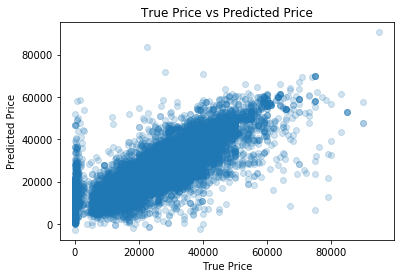

In [16]:
plt.scatter(labels, predictions, alpha=1/5)
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True Price vs Predicted Price")

In [13]:
labels = np.squeeze(y_test)
predictions = np.squeeze(y_pred)

In [14]:
from sklearn.metrics import r2_score

score = r2_score(labels, predictions)

print('R-squared score: {}'.format(score))

R-squared score: 0.6852950723699973


In [15]:
distances = np.abs(labels - predictions)

max_distance = np.max(distances)
min_distance = np.min(distances)
mean_distance = np.mean(distances)

print('Min distance: {}'.format(min_distance))
print('Max distance: {}'.format(max_distance))
print('Mean distance: {}'.format(mean_distance))

Min distance: 0.4667968999965524
Max distance: 68467.71679688
Mean distance: 4139.356900080963
